# Just an example.You can alter sample code anywhere. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import model
from tqdm import tqdm
import random

In [2]:
#Fix the random seed
np.random.seed(0)

## Load the training data and label

In [3]:
num_data = 60000
train_val_split = 0.8

In [4]:
train_load = np.loadtxt('./data/train.csv',delimiter=',',dtype="int")
test_data = np.loadtxt('./data/test.csv',delimiter=',',dtype="int")

train_data=train_load[:,1:]
train_label=train_load[:,0]

print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))
print("shape of test_data: {}".format(test_data.shape))

shape of train_data: (60000, 784)
shape of train_label: (60000,)
shape of test_data: (10000, 784)


In [5]:
train_data = train_data[0:num_data]
train_label = train_label[0:num_data]

## Show the training data

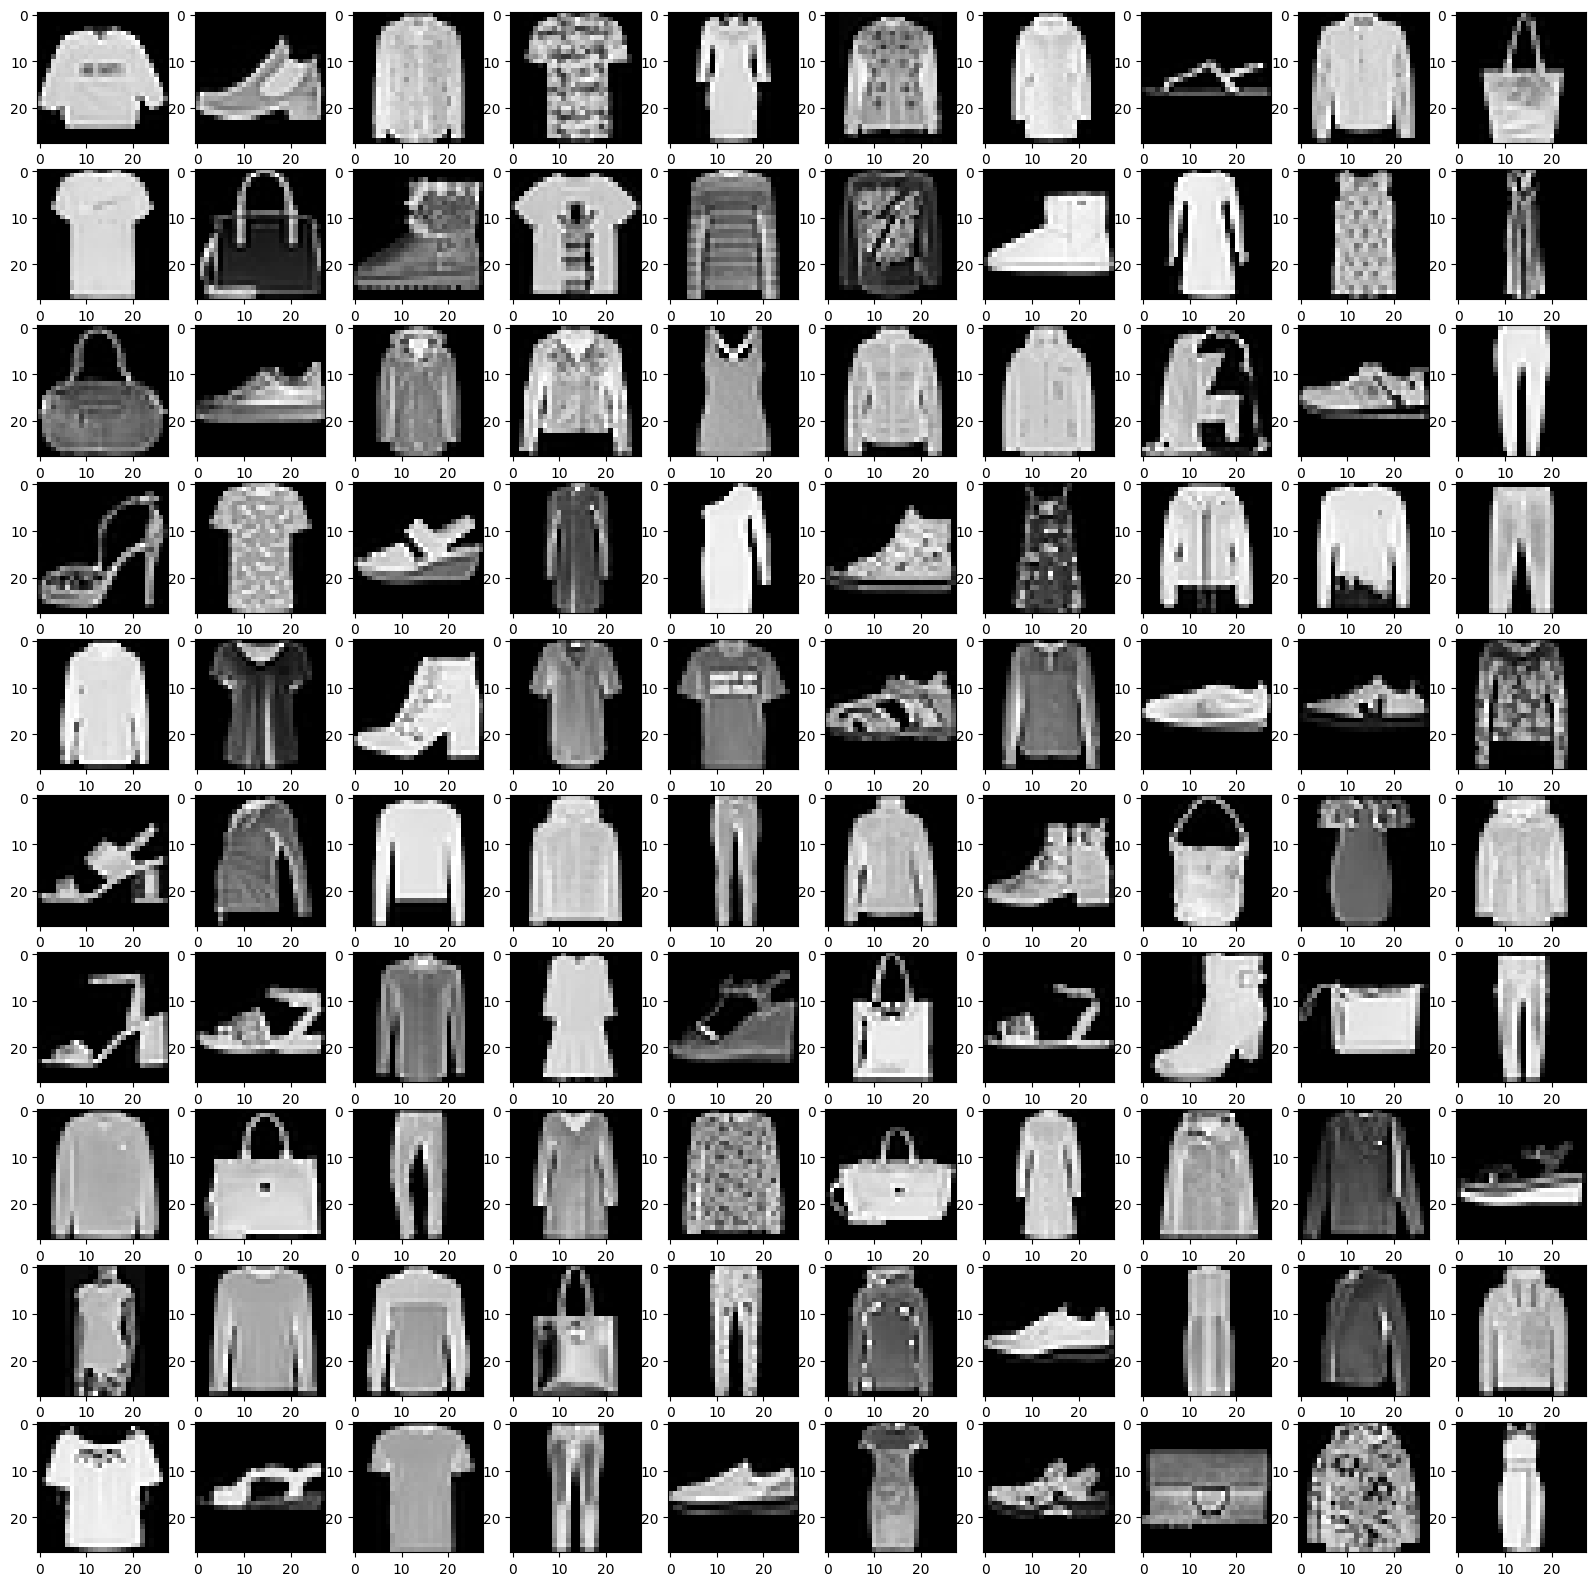

In [6]:
plt.figure(figsize=(20, 20))
for index in range(100):
    image = train_data[index].reshape(28,28)
    plt.subplot(10, 10, index+1)
    plt.imshow(image, cmap='gray')
plt.show()

In [7]:
train_image_num = train_data.shape[0]
test_image_num = test_data.shape[0]

print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))
print("shape of test_data: {}".format(test_data.shape))


print("train_image_num  is : {}".format(train_image_num))
print("test_image_num   is : {}".format(test_image_num))

shape of train_data: (60000, 784)
shape of train_label: (60000,)
shape of test_data: (10000, 784)
train_image_num  is : 60000
test_image_num   is : 10000


In [8]:
val_image_num = int(train_image_num * (1 - train_val_split))

## Convert the training labels to one hot vector

In [9]:
label_temp = np.zeros((train_image_num, 10), dtype = np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
print("One-hot training labels shape:",train_label_onehot.shape)

One-hot training labels shape: (60000, 10)


## Hyperparameters

In [10]:
EPOCH = 30
Batch_size = 1
Learning_rate = 1e-2
scheduler_step = 4

## Learning Rate Scheduler

In [11]:
lr_scheduler = [Learning_rate]*EPOCH

exp = 1
current_lr = Learning_rate
for idx, lr in enumerate(lr_scheduler):
    if idx != 0:
        if idx % scheduler_step == 0:
            lr_scheduler[idx] = lr * 0.5**exp
            exp += 1
            current_lr = lr_scheduler[idx]
        else:
            lr_scheduler[idx] = current_lr

In [12]:
print(lr_scheduler)

[0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00125, 0.00125, 0.00125, 0.000625, 0.000625, 0.000625, 0.000625, 0.0003125, 0.0003125, 0.0003125, 0.0003125, 0.00015625, 0.00015625, 0.00015625, 0.00015625, 7.8125e-05, 7.8125e-05]


## Shuffle

In [13]:
train_data = np.array(train_data)
train_label_onehot = np.array(train_label_onehot)

indices = np.arange(len(train_data))    
np.random.shuffle(indices)
 
train_data = train_data[indices]
train_label = train_label[indices]
train_label_onehot = train_label_onehot[indices]

## K-Fold Cross Validation

In [14]:
k = EPOCH
k_fold_train_data, k_fold_train_label, k_fold_train_label_onehot = [], [], []
k_fold_val_data, k_fold_val_label, k_fold_val_label_onehot = [], [], []

fold_len = int(len(train_data) / k)

for i in range(k):
    print("Generate & Shuffle Fold ", i)
    
    np.random.shuffle(indices)

    train_data = train_data[indices]
    train_label = train_label[indices]
    train_label_onehot = train_label_onehot[indices]
    start_idx = i * fold_len
    end_idx = (i + 1) * fold_len
    
    # training fold
    k_fold_train_data.append(np.vstack((train_data[:start_idx],train_data[end_idx:])))
    k_fold_train_label.append(np.hstack((train_label[:start_idx],train_label[end_idx:])))
    k_fold_train_label_onehot.append(np.vstack((train_label_onehot[:start_idx],train_label_onehot[end_idx:])))
    
    # validation fold
    k_fold_val_data.append(train_data[start_idx:end_idx])
    k_fold_val_label.append(train_label[start_idx:end_idx])
    k_fold_val_label_onehot.append(train_label_onehot[start_idx:end_idx])

Generate & Shuffle Fold  0
Generate & Shuffle Fold  1
Generate & Shuffle Fold  2
Generate & Shuffle Fold  3
Generate & Shuffle Fold  4
Generate & Shuffle Fold  5
Generate & Shuffle Fold  6
Generate & Shuffle Fold  7
Generate & Shuffle Fold  8
Generate & Shuffle Fold  9
Generate & Shuffle Fold  10
Generate & Shuffle Fold  11
Generate & Shuffle Fold  12
Generate & Shuffle Fold  13
Generate & Shuffle Fold  14
Generate & Shuffle Fold  15
Generate & Shuffle Fold  16
Generate & Shuffle Fold  17
Generate & Shuffle Fold  18
Generate & Shuffle Fold  19
Generate & Shuffle Fold  20
Generate & Shuffle Fold  21
Generate & Shuffle Fold  22
Generate & Shuffle Fold  23
Generate & Shuffle Fold  24
Generate & Shuffle Fold  25
Generate & Shuffle Fold  26
Generate & Shuffle Fold  27
Generate & Shuffle Fold  28
Generate & Shuffle Fold  29


## Training

In [15]:
net = model.Network()

history_train_loss, history_train_acc= [], []
history_val_loss, history_val_acc = [], []

# train_batch_num = (train_image_num  -  val_image_num)//Batch_size
# val_batch_num = (val_image_num)//Batch_size
# test_batch_num = test_image_num//Batch_size

train_num = len(k_fold_train_data[0])
val_num = len(k_fold_val_data[0])

for epoch in range(EPOCH):
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    
    # Training
    for i in tqdm(range(train_num)):
        pred, train_loss = net.forward(k_fold_train_data[epoch][i], k_fold_train_label_onehot[epoch][i].squeeze())
        pred_index = np.argmax(pred)
        train_hit += (pred_index==k_fold_train_label[epoch][i]).sum()
        total_train_loss += train_loss
        
        net.backward(k_fold_train_data[epoch][i], k_fold_train_label_onehot[epoch][i].squeeze(), lr_scheduler[epoch])
    
    # Validation
    for j in tqdm(range(val_num)):
        pred, val_loss = net.forward(k_fold_val_data[epoch][j], k_fold_val_label_onehot[epoch][j].squeeze())
        pred_index = np.argmax(pred)
        val_hit += (pred_index== k_fold_val_label[epoch][j]).sum()
        total_val_loss += val_loss
    
        
    print('Epoch:%3d'%(epoch+1), '|Train Loss:%8.4f'%(total_train_loss/train_num), '|Train Acc:%3.4f'%(train_hit/train_num*100.0)
          , '|Val Loss:%8.4f'%(total_val_loss/val_num), '|Val Acc:%3.4f'%(val_hit/val_num*100.0))
    
    history_train_loss.append(total_train_loss/train_num)
    history_train_acc.append(train_hit/train_num*100.0)
    history_val_loss.append(total_val_loss/val_num)
    history_val_acc.append(val_hit/val_num*100.0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.69it/s]


Epoch:  1 |Train Loss:  0.4784 |Train Acc:85.1500 |Val Loss:  0.3840 |Val Acc:86.7000


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.47it/s]


Epoch:  2 |Train Loss:  0.3302 |Train Acc:88.5690 |Val Loss:  0.3213 |Val Acc:88.9500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 104.94it/s]


Epoch:  3 |Train Loss:  0.3018 |Train Acc:89.4138 |Val Loss:  0.2871 |Val Acc:90.4500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.98it/s]


Epoch:  4 |Train Loss:  0.2888 |Train Acc:89.8776 |Val Loss:  0.2981 |Val Acc:89.9000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.92it/s]


Epoch:  5 |Train Loss:  0.2376 |Train Acc:91.6103 |Val Loss:  0.2122 |Val Acc:92.2000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.04it/s]


Epoch:  6 |Train Loss:  0.2281 |Train Acc:91.9879 |Val Loss:  0.2197 |Val Acc:92.2000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.30it/s]


Epoch:  7 |Train Loss:  0.2221 |Train Acc:92.1828 |Val Loss:  0.2340 |Val Acc:91.8500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.38it/s]


Epoch:  8 |Train Loss:  0.2174 |Train Acc:92.3328 |Val Loss:  0.2640 |Val Acc:91.4000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.16it/s]


Epoch:  9 |Train Loss:  0.1913 |Train Acc:93.3966 |Val Loss:  0.1912 |Val Acc:93.5000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 98.16it/s]


Epoch: 10 |Train Loss:  0.1871 |Train Acc:93.5103 |Val Loss:  0.1827 |Val Acc:93.0500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 94.96it/s]


Epoch: 11 |Train Loss:  0.1846 |Train Acc:93.4672 |Val Loss:  0.1800 |Val Acc:93.9000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.89it/s]


Epoch: 12 |Train Loss:  0.1815 |Train Acc:93.6172 |Val Loss:  0.1880 |Val Acc:93.4000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.75it/s]


Epoch: 13 |Train Loss:  0.1679 |Train Acc:94.2517 |Val Loss:  0.1716 |Val Acc:93.5000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.63it/s]


Epoch: 14 |Train Loss:  0.1660 |Train Acc:94.2879 |Val Loss:  0.1680 |Val Acc:94.1500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.72it/s]


Epoch: 15 |Train Loss:  0.1641 |Train Acc:94.3569 |Val Loss:  0.1754 |Val Acc:93.6500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.70it/s]


Epoch: 16 |Train Loss:  0.1630 |Train Acc:94.4431 |Val Loss:  0.1452 |Val Acc:94.6000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.00it/s]


Epoch: 17 |Train Loss:  0.1551 |Train Acc:94.7690 |Val Loss:  0.1615 |Val Acc:94.3500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.54it/s]


Epoch: 18 |Train Loss:  0.1547 |Train Acc:94.7397 |Val Loss:  0.1537 |Val Acc:95.1500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.14it/s]


Epoch: 19 |Train Loss:  0.1535 |Train Acc:94.7690 |Val Loss:  0.1604 |Val Acc:94.3500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.81it/s]


Epoch: 20 |Train Loss:  0.1533 |Train Acc:94.8121 |Val Loss:  0.1447 |Val Acc:95.4000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.43it/s]


Epoch: 21 |Train Loss:  0.1493 |Train Acc:95.0724 |Val Loss:  0.1485 |Val Acc:95.3000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 105.08it/s]


Epoch: 22 |Train Loss:  0.1486 |Train Acc:95.0207 |Val Loss:  0.1501 |Val Acc:95.3500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 96.86it/s]


Epoch: 23 |Train Loss:  0.1482 |Train Acc:95.0138 |Val Loss:  0.1472 |Val Acc:95.0500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.57it/s]


Epoch: 24 |Train Loss:  0.1480 |Train Acc:95.0759 |Val Loss:  0.1454 |Val Acc:95.3500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.15it/s]


Epoch: 25 |Train Loss:  0.1460 |Train Acc:95.1621 |Val Loss:  0.1412 |Val Acc:95.1500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 108.46it/s]


Epoch: 26 |Train Loss:  0.1459 |Train Acc:95.1828 |Val Loss:  0.1396 |Val Acc:95.5500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 107.99it/s]


Epoch: 27 |Train Loss:  0.1446 |Train Acc:95.2241 |Val Loss:  0.1658 |Val Acc:94.4000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.98it/s]


Epoch: 28 |Train Loss:  0.1450 |Train Acc:95.1621 |Val Loss:  0.1452 |Val Acc:95.1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.22it/s]


Epoch: 29 |Train Loss:  0.1438 |Train Acc:95.2259 |Val Loss:  0.1528 |Val Acc:94.7000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.19it/s]

Epoch: 30 |Train Loss:  0.1437 |Train Acc:95.2845 |Val Loss:  0.1518 |Val Acc:94.7500


## Plot Learning Curve

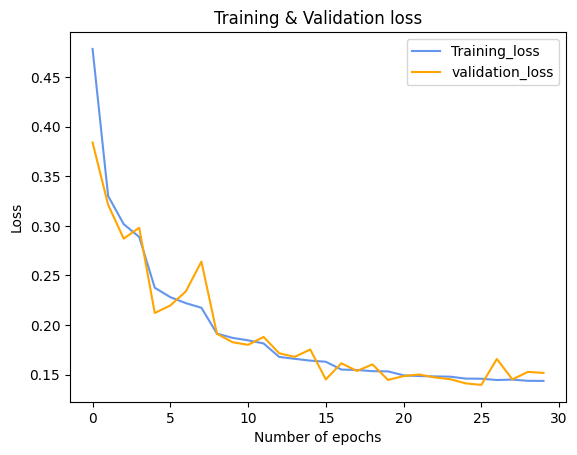

In [16]:
plt.plot(history_train_loss, color='cornflowerblue', label='Training_loss')
plt.plot(history_val_loss, color='orange', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

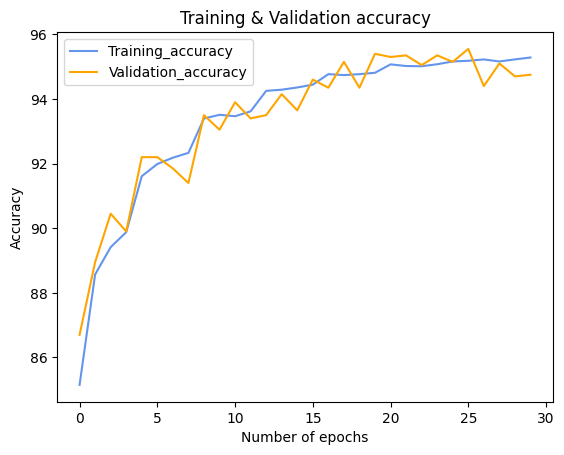

In [17]:
plt.plot(history_train_acc, color='cornflowerblue', label='Training_accuracy')
plt.plot(history_val_acc, color='orange', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Dump for evaluation (upload your DL-test-predict.csv to kaggle )

In [18]:
test_pred_list = []

for tit in tqdm(range(test_image_num//Batch_size)):
    pred, test_loss = net.forward(test_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
    pred_index = np.argmax(pred)
    test_pred_list.append(pred_index)
    # test_pred_list += pred_index.tolist()
    

print('Dump file...')
df = pd.DataFrame(test_pred_list, columns=["Category"])
df.to_csv('DL-test-predict.csv', index=True, index_label="Id")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:39<00:00, 62.64it/s]


Dump file...
